In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter

In [4]:
from imblearn.over_sampling import SMOTE,  ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import  DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report,confusion_matrix,accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [7]:
from google.colab import files
uploaded=files.upload()

Saving Fraud_check.csv to Fraud_check.csv


In [8]:
df=pd.read_csv("Fraud_check.csv")
df.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban  
0   YES  
1   YES  
2   YES  
3   YES  
4    NO

In [9]:
df.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [10]:
df.isnull().sum().sum()

0

In [11]:
df.shape

(600, 6)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [13]:
df[df.duplicated()].shape

(0, 6)

In [14]:
df[df.duplicated()]

Empty DataFrame
Columns: [Undergrad, Marital.Status, Taxable.Income, City.Population, Work.Experience, Urban]
Index: []

In [15]:
df.describe()

Taxable.Income  City.Population  Work.Experience
count      600.000000       600.000000       600.000000
mean     55208.375000    108747.368333        15.558333
std      26204.827597     49850.075134         8.842147
min      10003.000000     25779.000000         0.000000
25%      32871.500000     66966.750000         8.000000
50%      55074.500000    106493.500000        15.000000
75%      78611.750000    150114.250000        24.000000
max      99619.000000    199778.000000        30.000000

In [16]:
# Converting taxable_income <= 30000 as "Risky" and others are "Good"
df1=df.copy()
df1['taxable_category'] = pd.cut(x = df1['Taxable.Income'], bins = [10002,30000,99620], labels = ['Risky', 'Good'])
df1.head()

Undergrad Marital.Status  Taxable.Income  City.Population  Work.Experience  \
0        NO         Single           68833            50047               10   
1       YES       Divorced           33700           134075               18   
2        NO        Married           36925           160205               30   
3       YES         Single           50190           193264               15   
4        NO        Married           81002            27533               28   

  Urban taxable_category  
0   YES             Good  
1   YES             Good  
2   YES             Good  
3   YES             Good  
4    NO             Good

In [17]:
categorical_features = df.describe(include=["object"]).columns
categorical_features

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')

In [18]:
numerical_features = df.describe(include=["int64"]).columns
numerical_features

Index(['Taxable.Income', 'City.Population', 'Work.Experience'], dtype='object')

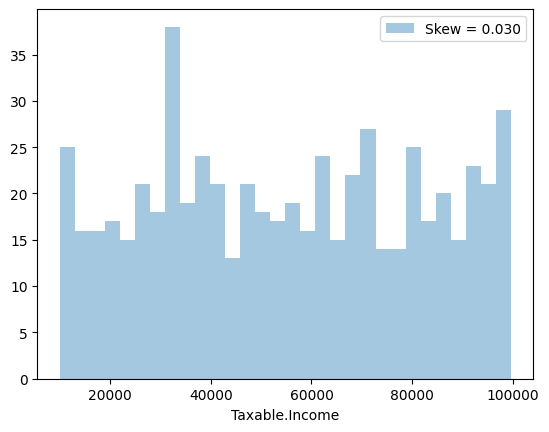

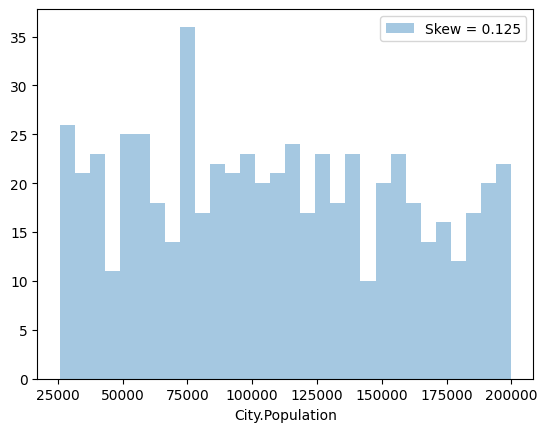

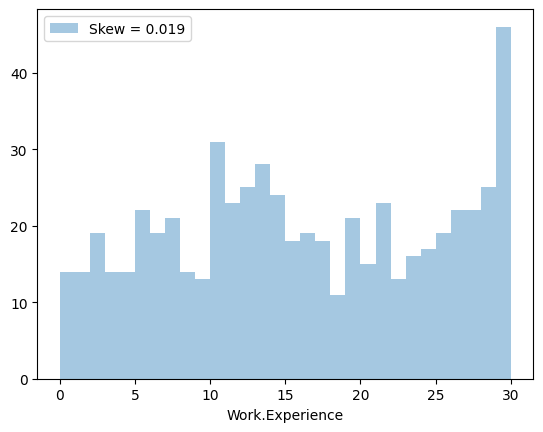

In [19]:
numerical_features=[feature for feature in df.columns if df[feature].dtypes != 'O']
for feat in numerical_features:
    skew = df[feat].skew()
    sns.distplot(df[feat], kde= False, label='Skew = %.3f' %(skew), bins=30)
    plt.legend(loc='best')
    plt.show()

In [20]:
# Detect observations with more than one outlier

def outlier_hunt(df):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than 2 outliers.
    """
    outlier_indices = []

    # iterate over features(columns)
    for col in df.columns.tolist():
        Q1 = np.percentile(df[col], 25)

        Q3 = np.percentile(df[col],75)


        IQR = Q3 - Q1

        # outlier step
        outlier_step = 1.5 * IQR

        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2 )

    return multiple_outliers

print('The dataset contains %d observations with more than 2 outliers' %(len(outlier_hunt(df[numerical_features]))))

The dataset contains 0 observations with more than 2 outliers


In [21]:
numerical_features

['Taxable.Income', 'City.Population', 'Work.Experience']

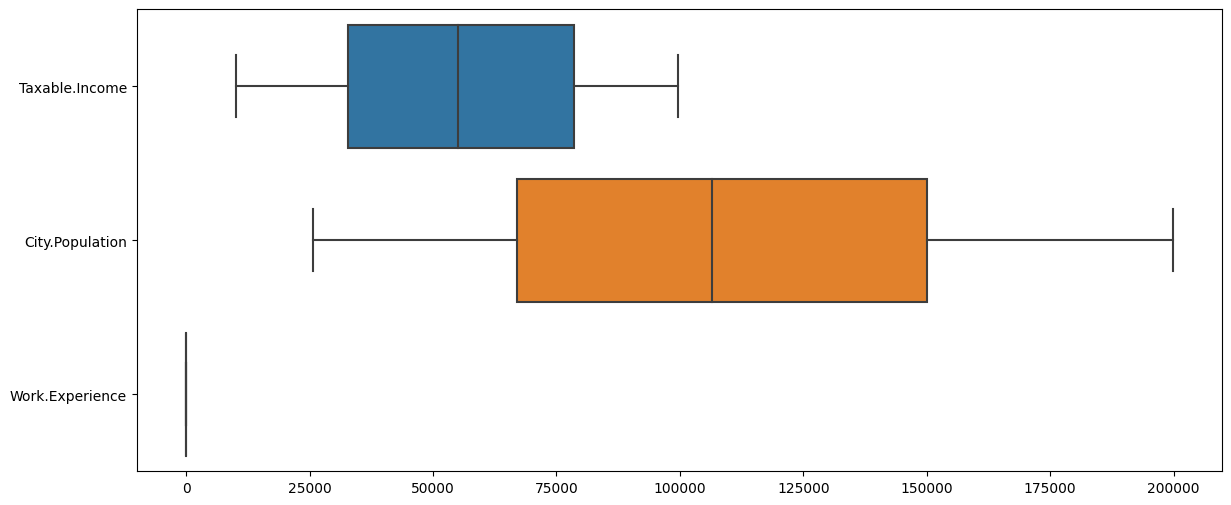

In [22]:
#outlier
plt.figure(figsize=(14,6))
sns.boxplot(data=df[numerical_features], orient="h");

<Axes: >

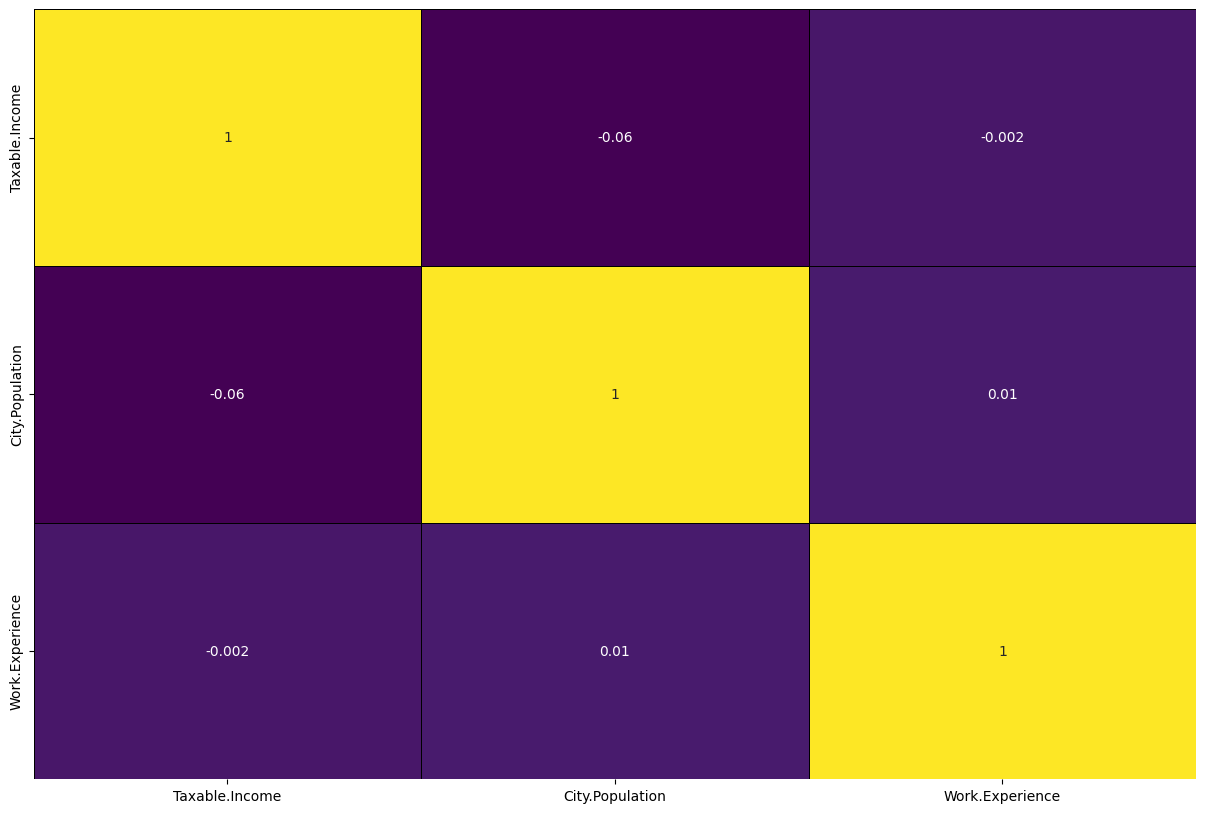

In [23]:
# Having a look at the correlation matrix

fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.1g', cmap="viridis", cbar=False, linewidths=0.5, linecolor='black')

Index(['Undergrad', 'Marital.Status', 'Urban'], dtype='object')


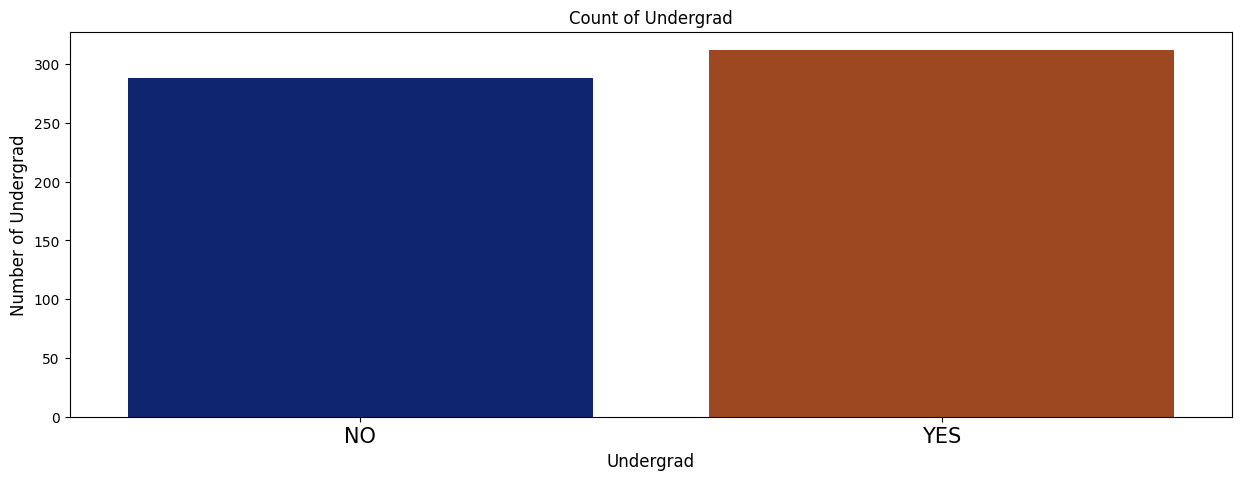

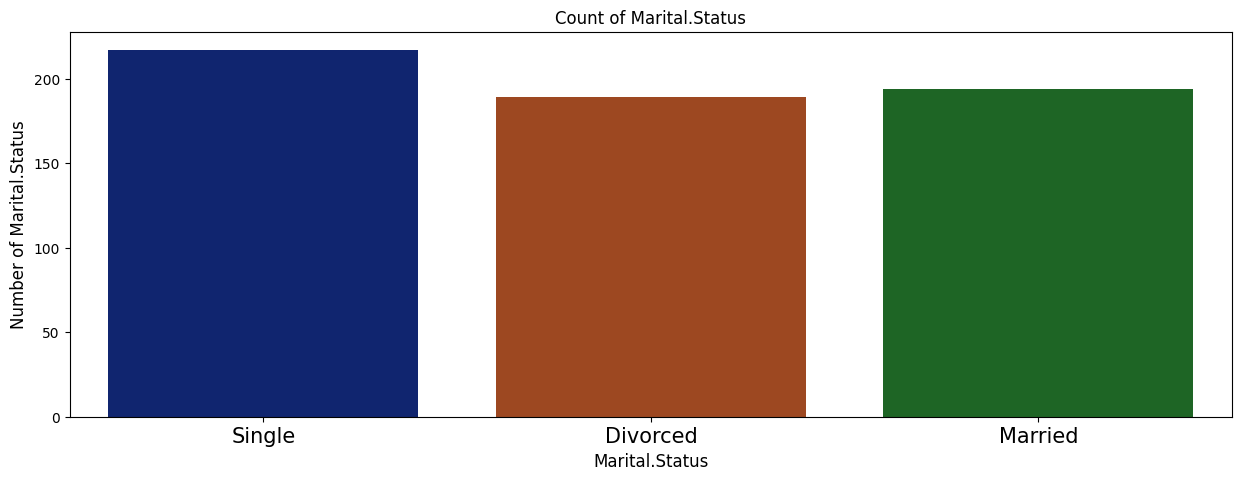

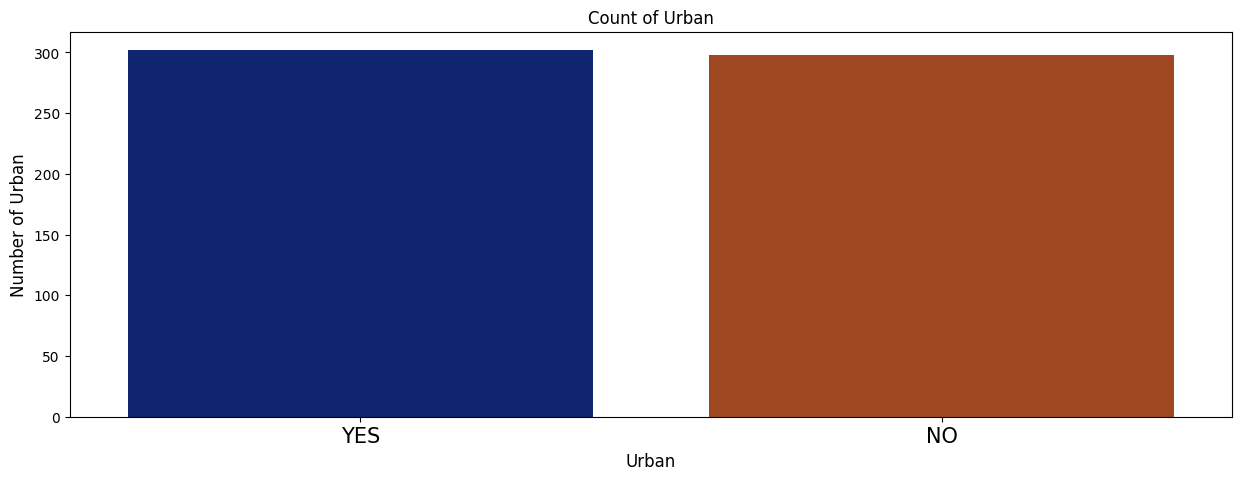

In [24]:
print(categorical_features)

for idx, column in enumerate(categorical_features):
    plt.figure(figsize=(15, 5))
    unique = df[column].value_counts(ascending=True);

    #plt.subplot(1, len(categorical_features), idx+1)
    plt.title("Count of "+ column)
    sns.countplot(data=df, x=column,palette = "dark")
    #plt.bar(unique.index, unique.values);
    plt.xticks(rotation = 0, size = 15)

    plt.xlabel(column, fontsize=12)
    plt.ylabel("Number of "+ column, fontsize=12)

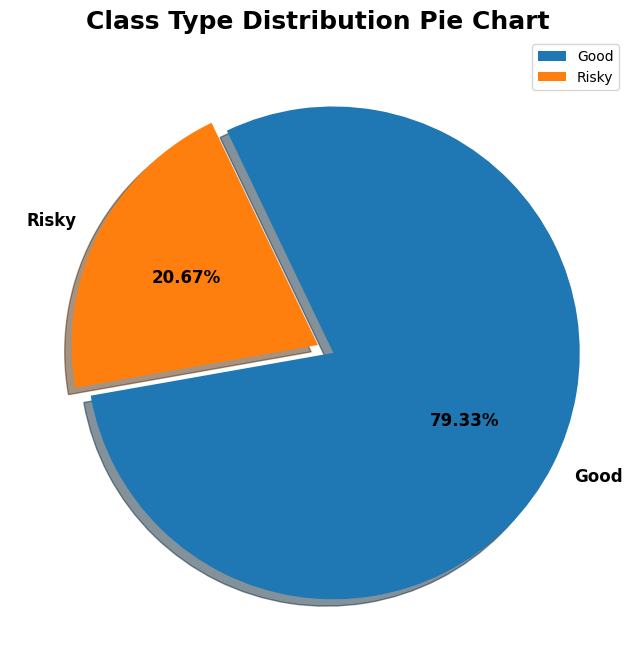

In [29]:
plt.figure(figsize = (12,8))
plt.pie(df1['taxable_category'].value_counts(),
       labels=df1.taxable_category.unique(),
       explode = [0.07,0.0],
       autopct= '%.2f%%',
       shadow= True,
       startangle= 190,
       textprops = {'size':'large',
                   'fontweight':'bold',
                    'rotation':0,
                   'color':'black'})
plt.legend(loc= 'upper right')
plt.title("Class Type Distribution Pie Chart", fontsize = 18, fontweight = 'bold')
plt.show()

In [30]:
df1.taxable_category.value_counts()

Good     476
Risky    124
Name: taxable_category, dtype: int64

In [31]:
data = df1.copy()
data.rename(columns={'Marital.Status':'Marital_Status', 'Taxable.Income':'Taxable_Income','Work.Experience':'Work_Experience','City.Population':'City_Population'}, inplace = True)
data.drop('Taxable_Income', axis=1, inplace = True)
categorical_features = data.describe(include=["object",'category']).columns
categorical_features

Index(['Undergrad', 'Marital_Status', 'Urban', 'taxable_category'], dtype='object')

In [32]:
#Creating dummy vairables of the categorical features
le = LabelEncoder()
for col in categorical_features:
        le.fit(data[col])
        data[col] = le.transform(data[col])
data.head()

Undergrad  Marital_Status  City_Population  Work_Experience  Urban  \
0          0               2            50047               10      1   
1          1               0           134075               18      1   
2          0               1           160205               30      1   
3          1               2           193264               15      1   
4          0               1            27533               28      0   

   taxable_category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [33]:
data.taxable_category.value_counts()

0    476
1    124
Name: taxable_category, dtype: int64

In [34]:
x = data.drop('taxable_category',axis=1)
y = data['taxable_category']

In [35]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in skf.split(x, y):
    train_X, test_X = x.iloc[train_ix], x.loc[test_ix]
    train_y, test_y = y.iloc[train_ix], y.iloc[test_ix]

    train, train1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test, test1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train, train1, test, test1))

>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=428, 1=112, Test: 0=48, 1=12
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13
>Train: 0=429, 1=111, Test: 0=47, 1=13


In [36]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0,stratify=y)

In [37]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=333, 1=87, Test: 0=143, 1=37


In [38]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

In [39]:
params = {
    "criterion":("gini", "entropy"),
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 20))),
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":list(range(1, 20)),
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(train_X, train_y)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(train_X, train_y)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=True)
print_score(tree_clf, train_X, train_y, test_X, test_y, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0      1  accuracy   macro avg  weighted avg
precision    0.794444    0.0  0.794444    0.397222      0.631142
recall       1.000000    0.0  0.794444    0.500000      0.794444
f1-score     0.885449    0.0  0.794444    0.442724      0.703440
support    429.000000  111.0  0.794444  540.000000    540.000000
_______________________________________________
Confusion Matrix: 
 [[429   0]
 [111   0]]

Test Result:
Accuracy Score: 78.33%
_______________________________________________
CLASSIFICATION REPORT:
                   0     1  accuracy  macro avg  weighted avg
precision   0.783333   0.0  0.783333   0.391667      0.613611
recall      1.000000   0.0  0.783333   0.500000      0.7

In [40]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, train_X, train_y, cv=skf)
print(results.mean())

0.6166666666666667


In [42]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(train_X,train_y)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [44]:
grid.best_score_

0.7944444444444444

In [45]:
predict_output = model.predict(test_X)
accuracy_test = accuracy_score(test_y,predict_output)
accuracy_test

0.7833333333333333

In [46]:
print(classification_report(test_y,predict_output))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88        47
           1       0.00      0.00      0.00        13

    accuracy                           0.78        60
   macro avg       0.39      0.50      0.44        60
weighted avg       0.61      0.78      0.69        60



In [48]:
params = {
    "criterion":("gini", "entropy"),
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 20))),
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":list(range(1, 20)),
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best paramters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 79.29%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.792857   0.0  0.792857    0.396429      0.628622
recall       1.000000   0.0  0.792857    0.500000      0.792857
f1-score     0.884462   0.0  0.792857    0.442231      0.701252
support    333.000000  87.0  0.792857  420.000000    420.000000
_______________________________________________
Confusion Matrix: 
 [[333   0]
 [ 87   0]]

Test Result:
Accuracy Score: 79.44%
_______________________________________________
CLASSIFICATION REPORT:
                    0     1  accuracy   macro avg  weighted avg
precision    0.794444   0.0  0.794444    0.397222      0.631142
recall       1.000000   0.0  0.794444    0.500000      0.

In [50]:
# Get score for different values of n
decision_tree = DecisionTreeClassifier()
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

results = cross_val_score(decision_tree, x_train, y_train, cv=skf)
print(results.mean())

0.630952380952381


In [51]:
param_dict = {
    "criterion":["gini","entropy"],
    "max_depth":range(1,10),
    "min_samples_split":range(1,10),
    "min_samples_leaf":range(1,10)
}

grid = GridSearchCV(decision_tree,
                   param_grid = param_dict,
                   cv=skf,
                   verbose=1,
                   n_jobs=6)

grid.fit(x_train,y_train)

model = grid.best_estimator_

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


In [52]:
grid.best_score_

0.7928571428571429

In [53]:
predict_output = model.predict(x_test)
accuracy_test = accuracy_score(y_test,predict_output)
accuracy_test

0.7944444444444444

In [54]:
print(classification_report(y_test,predict_output))

              precision    recall  f1-score   support

           0       0.79      1.00      0.89       143
           1       0.00      0.00      0.00        37

    accuracy                           0.79       180
   macro avg       0.40      0.50      0.44       180
weighted avg       0.63      0.79      0.70       180



In [55]:
x = data.drop(['taxable_category'], axis=1)
y = data['taxable_category']

x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=0,stratify=y)

In [56]:
# summarize
train_0, train_1 = len(y_train[y_train==0]), len(y_train[y_train==1])
test_0, test_1 = len(y_test[y_test==0]), len(y_test[y_test==1])
print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))


>Train: 0=333, 1=87, Test: 0=143, 1=37


In [57]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
x_train_sm, y_train_sm = smt.fit_resample(x_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 333})


In [58]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
x_train_ada, y_train_ada = ada.fit_resample(x_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 333, 1: 327})


In [59]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
x_train_smtom, y_train_smtom = smtom.fit_resample(x_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 239, 1: 239})


In [60]:
counter = Counter(y_train)
print('Before',counter)
#oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
x_train_smenn, y_train_smenn = smenn.fit_resample(x_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({1: 77, 0: 73})


In [64]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
sm = SMOTE(sampling_strategy = .3)
rus =  RandomUnderSampler(sampling_strategy=.4)

pipeline = Pipeline(steps = [('smote', sm),('under',rus)])

counter = Counter(y_train)
print('Before',counter)
#over and undersampling the train dataset using SMOTE + RandomUnderSampler
x_train_smrus, y_train_smrus = pipeline.fit_resample(x_train, y_train)

counter = Counter(y_train_smrus)
print('After',counter)

Before Counter({0: 333, 1: 87})
After Counter({0: 247, 1: 99})


In [65]:
#### As the results can be compared, SMOTE TOMEK Hybridization technique gave the best results we are going to use it further

In [66]:
counter = Counter(y)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=0)
x_train_smtom, y_train_smtom = smtom.fit_resample(x, y)

counter = Counter(y_train_smtom)
print('After',counter)

Before Counter({0: 476, 1: 124})
After Counter({0: 354, 1: 354})


In [67]:
x_train,x_test,y_train,y_test = train_test_split(x_train_smtom,y_train_smtom,test_size=0.3,random_state=0, stratify=y_train_smtom)

counter = Counter(y_train_smtom)
print('Before',counter)
counter = Counter(y_train)
print('After',counter)

Before Counter({0: 354, 1: 354})
After Counter({1: 248, 0: 247})


In [68]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

params = {
    "criterion":("gini", "entropy"),
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 6))),
    "min_samples_split":[2, 3, 4],
    "min_samples_leaf":list(range(1, 6)),
}


tree_clf = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_clf, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=10)
tree_cv.fit(x_train, y_train)
best_params = tree_cv.best_params_
print(f"Best paramters: {best_params})")

tree_clf = DecisionTreeClassifier(**best_params)
tree_clf.fit(x_train, y_train)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits
Best paramters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'})
Train Result:
Accuracy Score: 72.53%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.796791    0.681818  0.725253    0.739305      0.739189
recall       0.603239    0.846774  0.725253    0.725007      0.725253
f1-score     0.686636    0.755396  0.725253    0.721016      0.721085
support    247.000000  248.000000  0.725253  495.000000    495.000000
_______________________________________________
Confusion Matrix: 
 [[149  98]
 [ 38 210]]

Test Result:
Accuracy Score: 63.38%
_______________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy   macro avg  weighted avg
precision    0.745763    0.590909  0.633803    0.668336      0.668699
recall       

In [69]:
model_entropy = DecisionTreeClassifier(criterion='entropy', random_state=0)
model_entropy.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

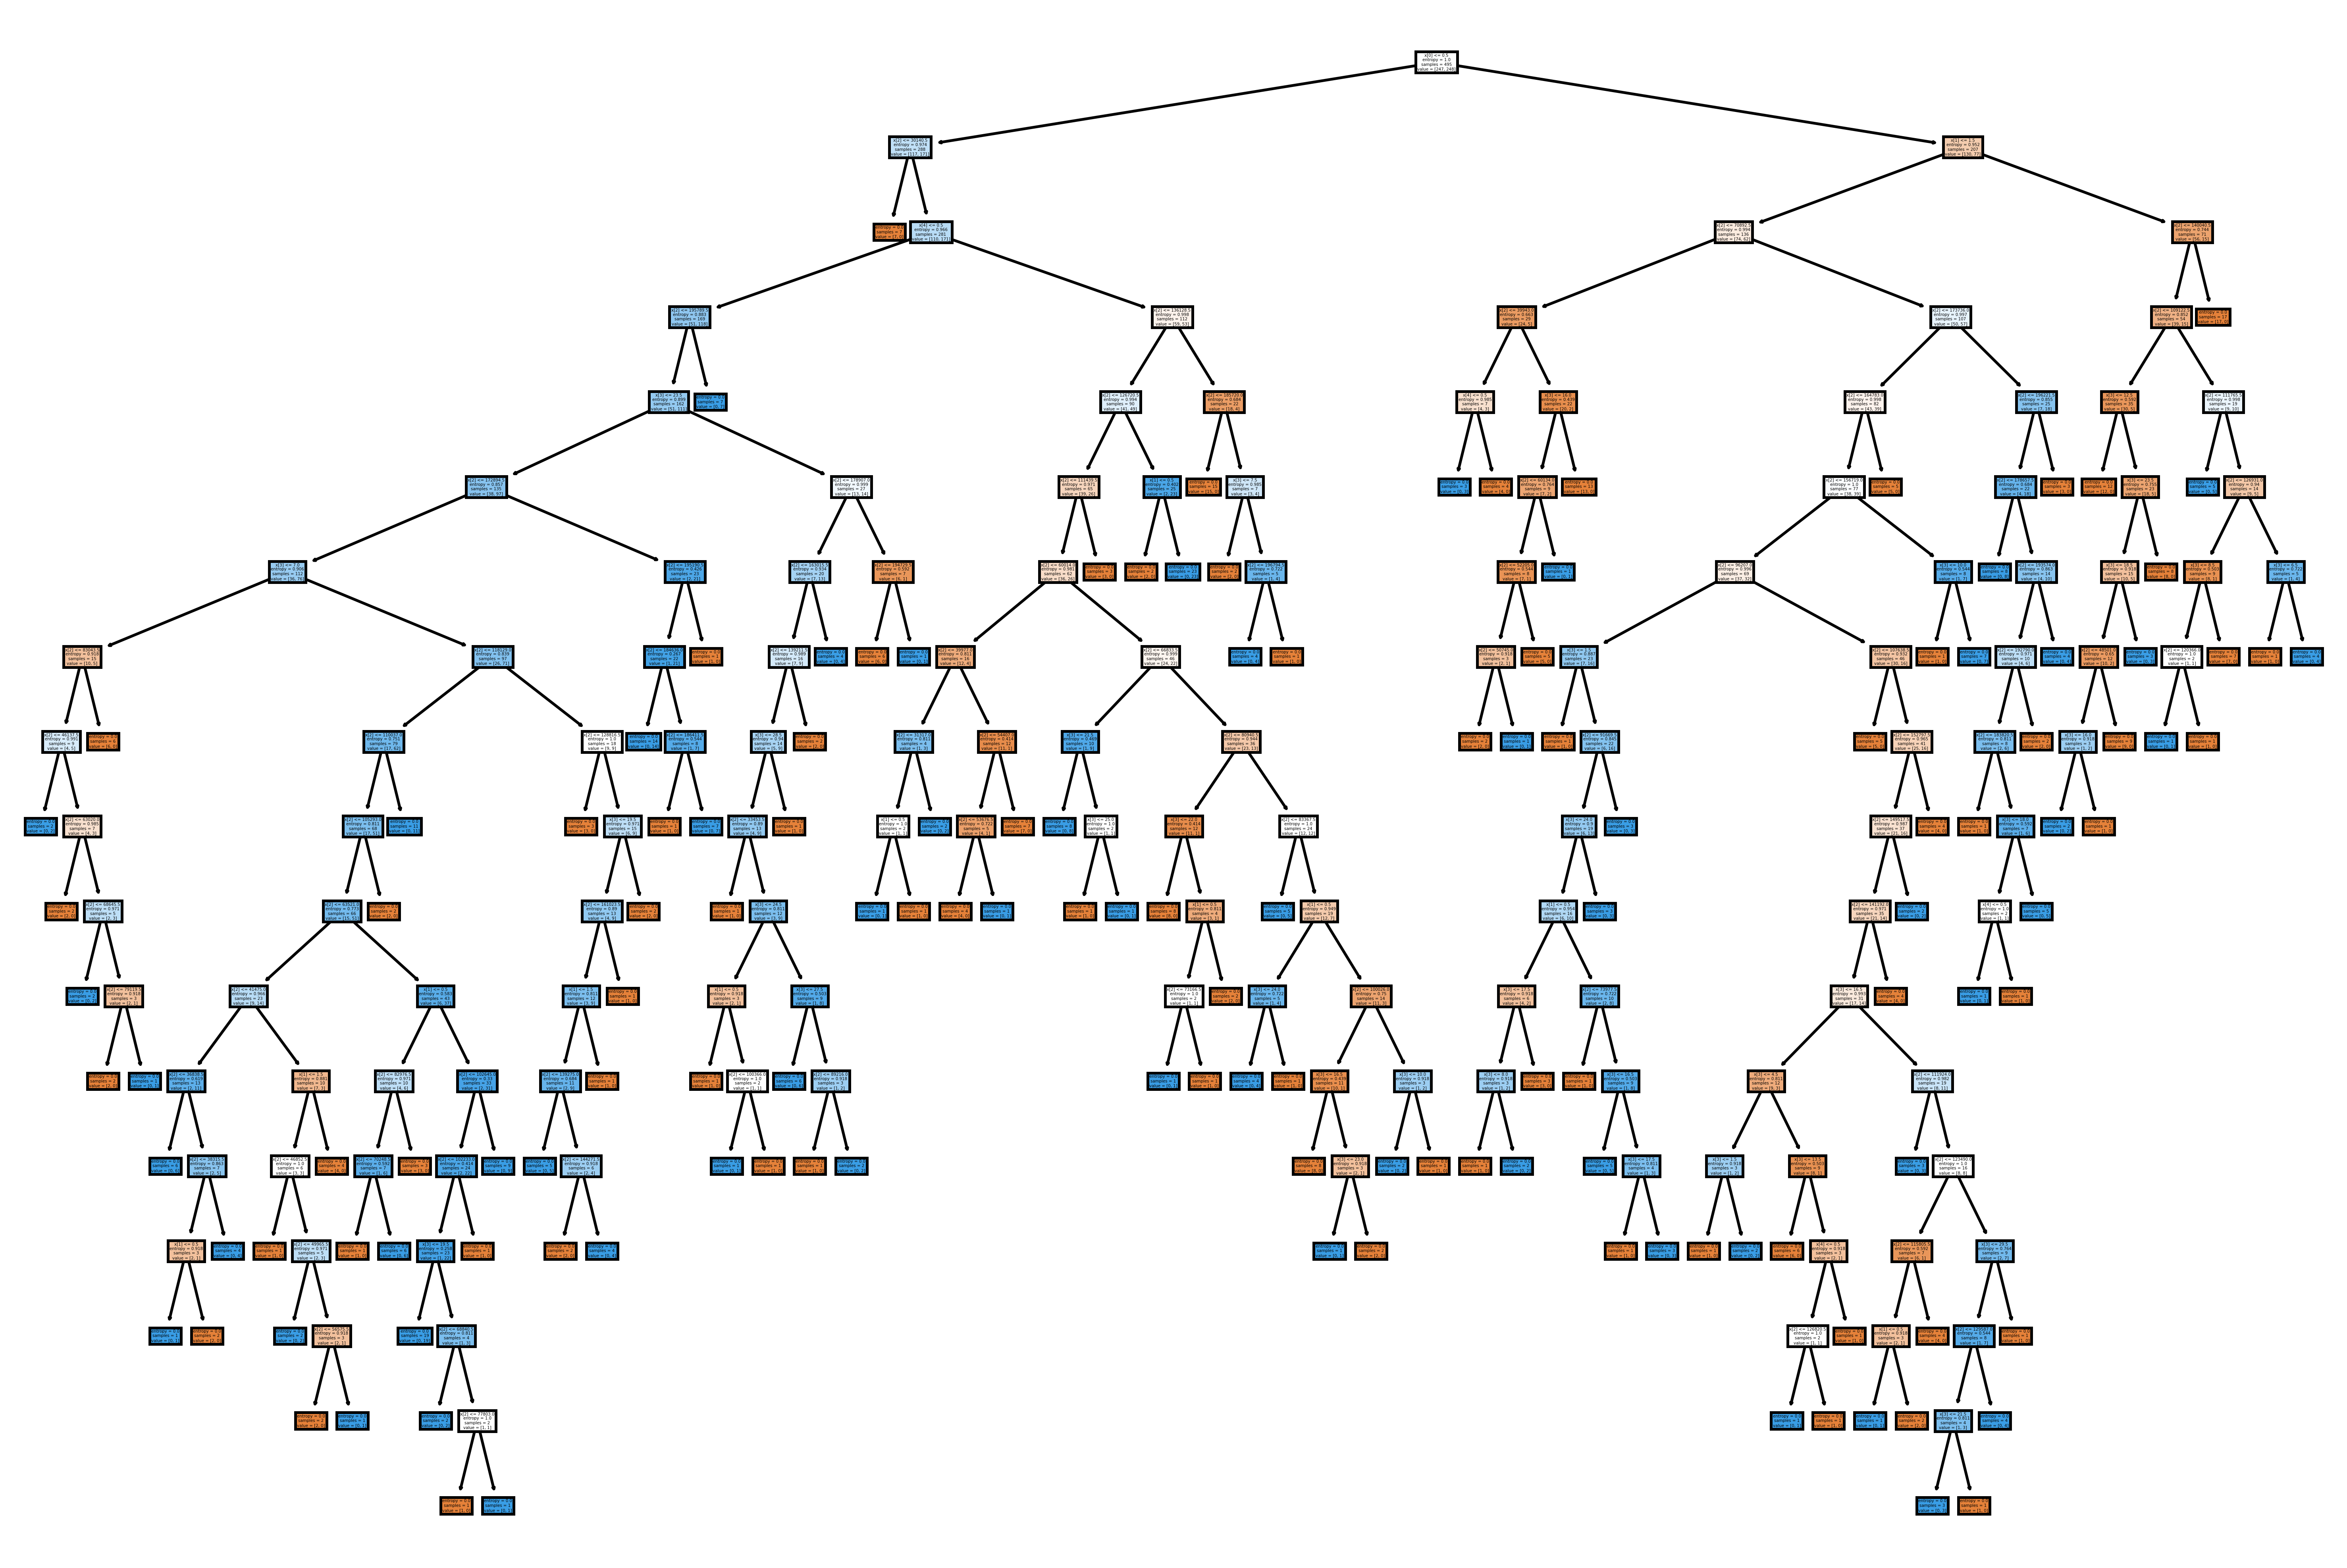

In [70]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_entropy,filled=True)
plt.show()

In [71]:
#Predicting on test data
preds = model_entropy.predict(x_test) # predicting on test data set
pd.Series(preds).value_counts() # getting the count of each category

1    114
0     99
dtype: int64

In [72]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0              0   1
taxable_category        
0                 72  35
1                 27  79

In [73]:
# Accuracy
np.mean(preds==y_test)

0.7089201877934272

In [74]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70       107
           1       0.69      0.75      0.72       106

    accuracy                           0.71       213
   macro avg       0.71      0.71      0.71       213
weighted avg       0.71      0.71      0.71       213



In [75]:
path = model_entropy.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [76]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.03483671449999548


In [77]:
clf = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=0.00983548)
clf.fit(x_train,y_train)


DecisionTreeClassifier(ccp_alpha=0.00983548, criterion='entropy',
                       random_state=0)

In [78]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7272727272727273 
Testing Accuracy 0.6525821596244131


In [79]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       107
           1       0.64      0.71      0.67       106

    accuracy                           0.65       213
   macro avg       0.65      0.65      0.65       213
weighted avg       0.65      0.65      0.65       213



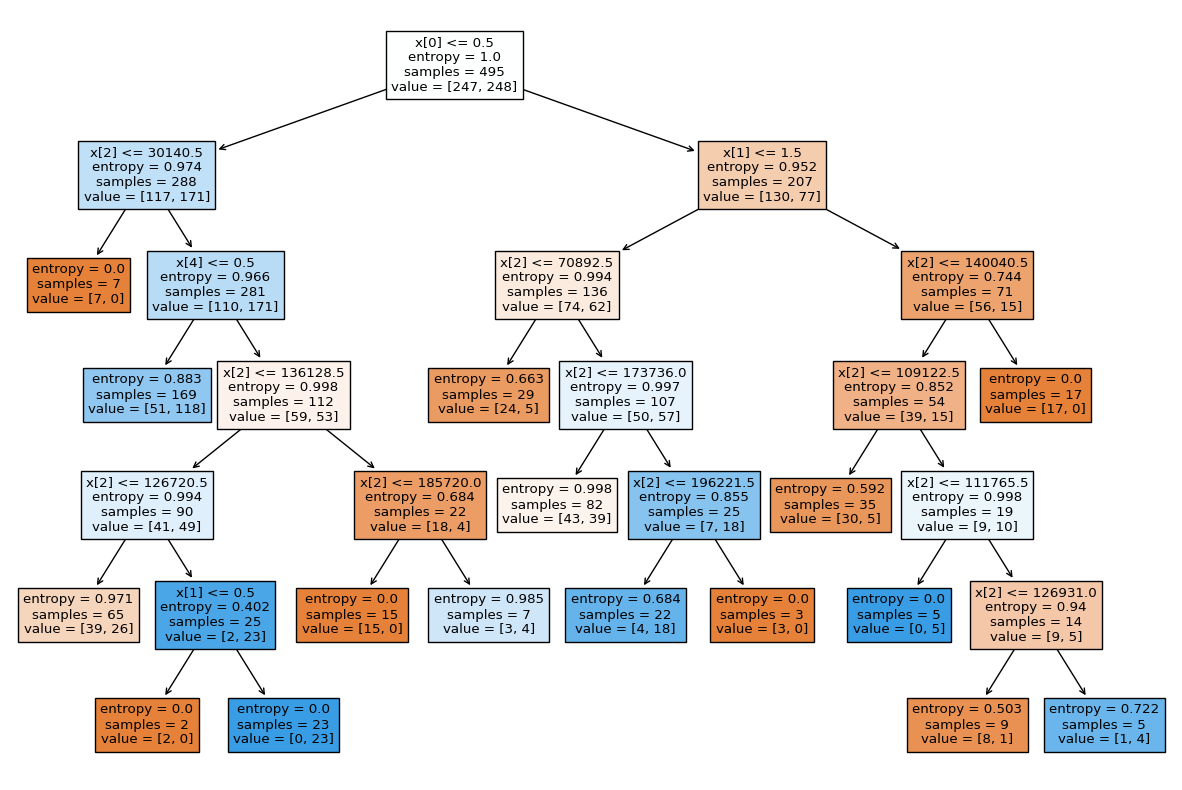

In [80]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()


In [81]:
model_gini = DecisionTreeClassifier(criterion='gini', random_state=0)
model_gini.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

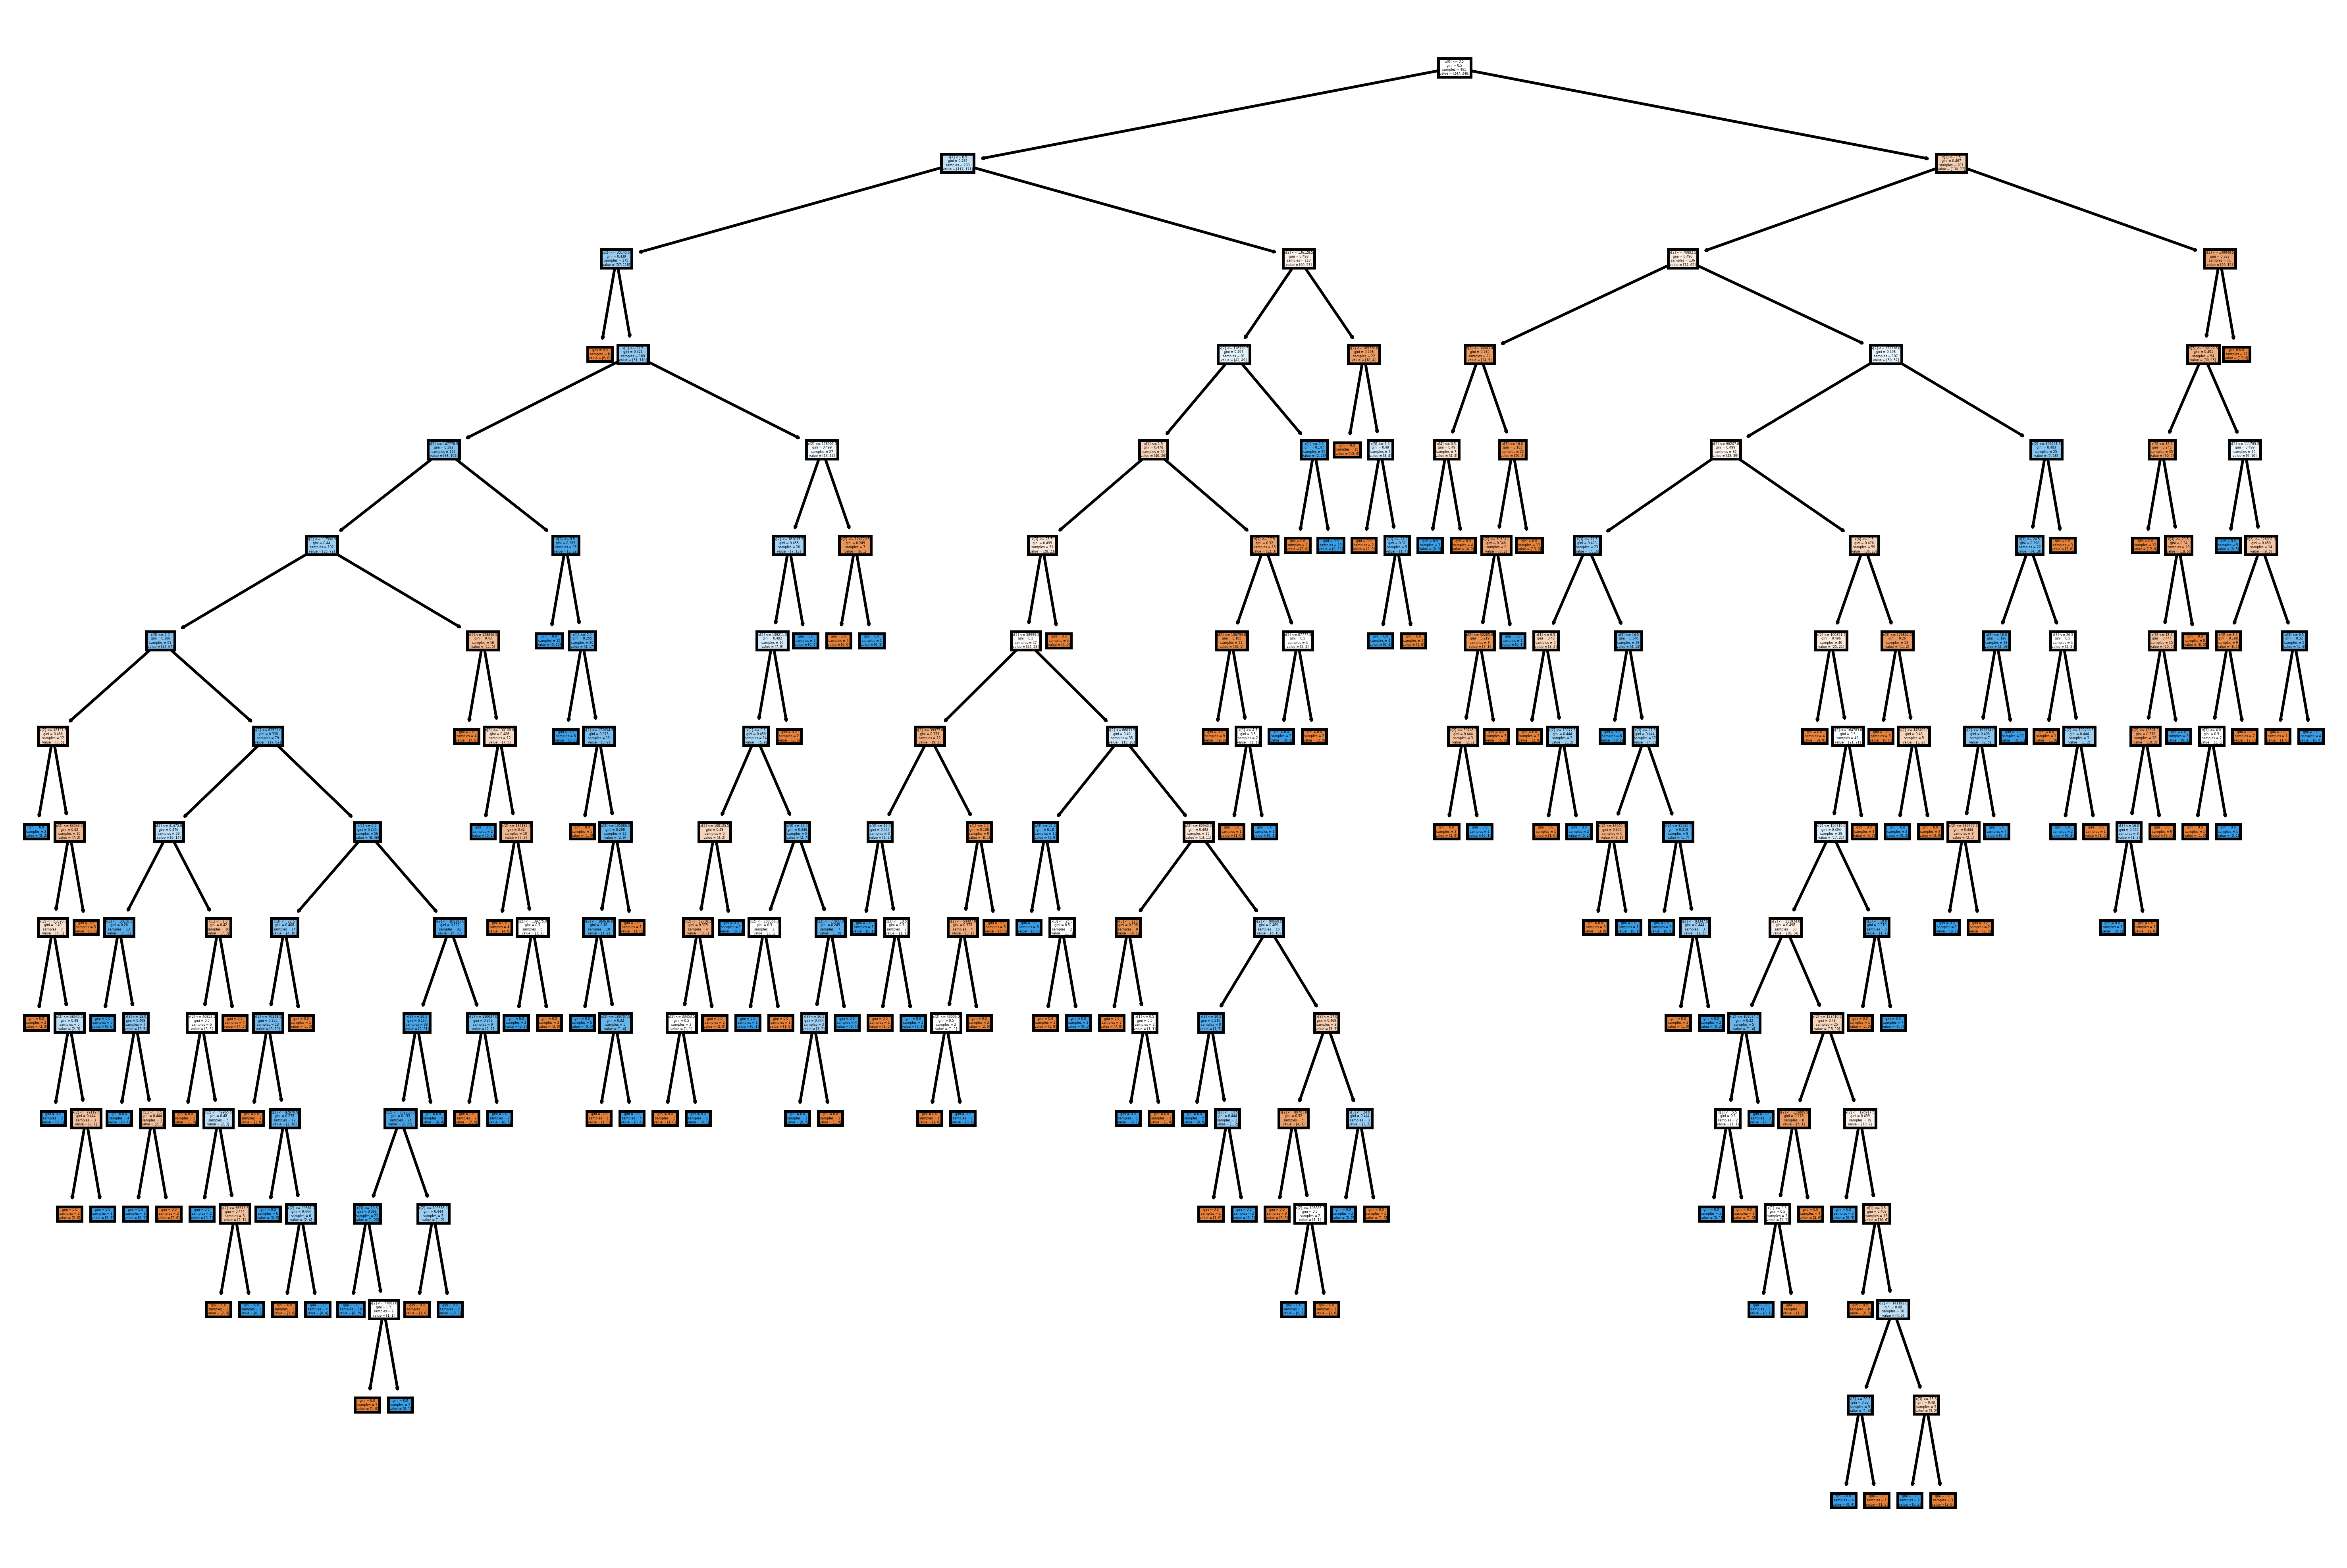

In [82]:
plt.figure(figsize=(15,10),dpi=500)
tree.plot_tree(model_gini,filled=True)
plt.show()

In [83]:
#Predicting on test data
preds = model_gini.predict(x_test) # predicting on test data set
pd.Series(preds).value_counts() # getting the count of each category

1    124
0     89
dtype: int64

In [84]:
pd.crosstab(y_test,preds) # getting the 2 way table to understand the correct and wrong predictions

col_0              0   1
taxable_category        
0                 64  43
1                 25  81

In [85]:
# Accuracy
np.mean(preds==y_test)

0.6807511737089202

In [86]:
# Classification Report
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.72      0.60      0.65       107
           1       0.65      0.76      0.70       106

    accuracy                           0.68       213
   macro avg       0.69      0.68      0.68       213
weighted avg       0.69      0.68      0.68       213



In [87]:
path = model_gini.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [88]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.023932351623392523


In [89]:
clf = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=0.00600582)
clf.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00600582, random_state=0)

In [90]:
pred_test=clf.predict(x_test)
pred_train=clf.predict(x_train)
from sklearn.metrics import accuracy_score
print('Training Accuracy',accuracy_score(y_train, pred_train),'\n'
'Testing Accuracy',accuracy_score(y_test, pred_test))

Training Accuracy 0.7414141414141414 
Testing Accuracy 0.6619718309859155


In [91]:
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       107
           1       0.64      0.72      0.68       106

    accuracy                           0.66       213
   macro avg       0.66      0.66      0.66       213
weighted avg       0.66      0.66      0.66       213



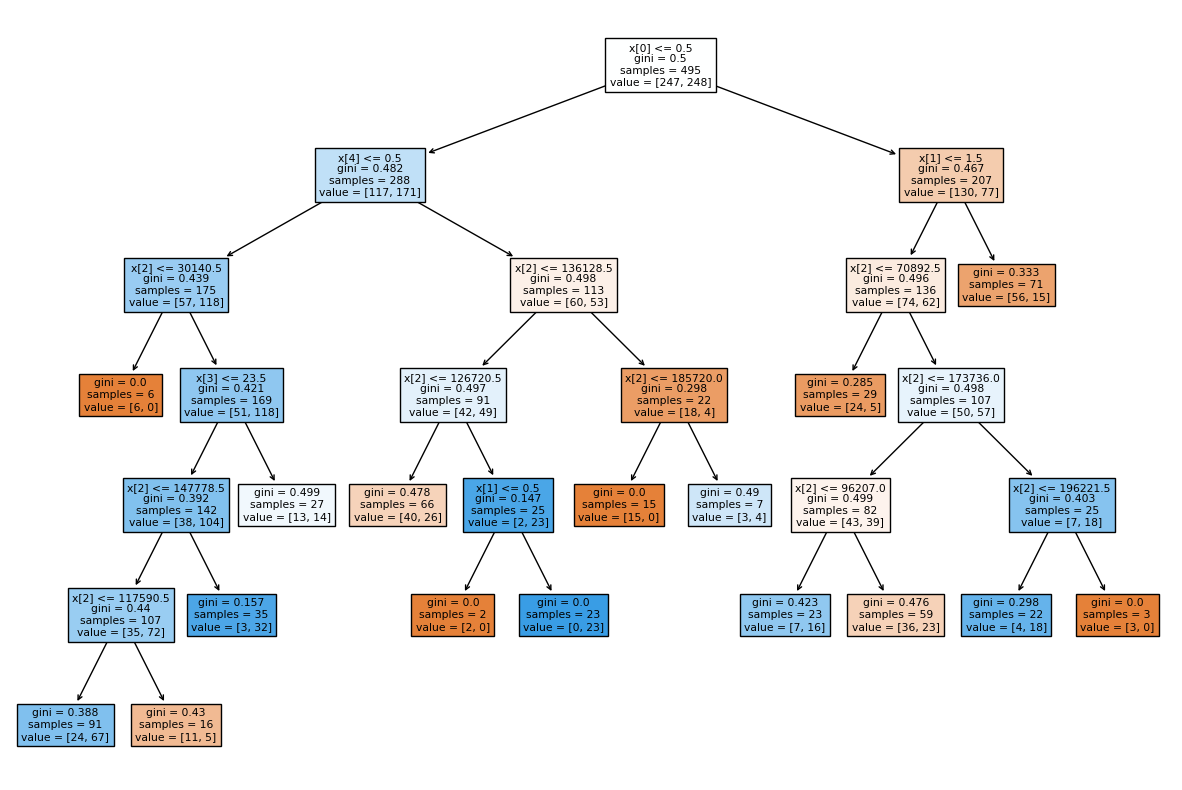

In [92]:
plt.figure(figsize=(15,10))
tree.plot_tree(clf,filled=True)
plt.show()